In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import io

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from google.colab import files

In [ ]:

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded.popitem()[1]))

Saving aquasense_ai_simulated_data.csv to aquasense_ai_simulated_data.csv


In [ ]:
df.head(5)

,timestamp,zone,pressure,flow,temperature,label
0,2025-04-01 08:00:00,Zone C,2.67,13.57,25,normal
1,2025-04-01 08:05:00,Zone C,2.75,15.04,25,normal
2,2025-04-01 08:10:00,Zone C,2.94,14.19,20,normal
3,2025-04-01 08:15:00,Zone C,2.21,20.01,22,leak
4,2025-04-01 08:20:00,Zone B,2.52,15.40,18,normal


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp']).map(pd.Timestamp.toordinal)

df = pd.get_dummies(df, columns=['zone'], prefix='zone')

In [ ]:

y = pd.factorize(df.pop('label'))[0]
X = df.values.astype(np.float32)

X_train, X_test = X[:8000], X[8000:]
y_train, y_test = y[:8000], y[8000:]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test: ", X_test.shape,  "y_test: ",  y_test.shape)

X_train: (8000, 7) y_train: (8000,)
X_test:  (2000, 7) y_test:  (2000,)


In [ ]:
model = keras.Sequential([
    keras.layers.Dense(units= X_train.shape[1], activation='tanh', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(units=64, activation='tanh'),
    keras.layers.Dense(units=32, activation='tanh'),
    keras.layers.Dense(units=16, activation='tanh'),
    keras.layers.Dense(units=2, activation='softmax'),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=32,
    verbose = 2
)

Epoch 1/25
225/225 - 3s - 11ms/step - accuracy: 0.8878 - loss: 0.3391 - val_accuracy: 0.9025 - val_loss: 0.3222
Epoch 2/25
225/225 - 1s - 2ms/step - accuracy: 0.8989 - loss: 0.3296 - val_accuracy: 0.9025 - val_loss: 0.3196
Epoch 3/25
225/225 - 1s - 2ms/step - accuracy: 0.8989 - loss: 0.3294 - val_accuracy: 0.9025 - val_loss: 0.3196
Epoch 4/25
225/225 - 1s - 3ms/step - accuracy: 0.8989 - loss: 0.3288 - val_accuracy: 0.9025 - val_loss: 0.3234
Epoch 5/25
225/225 - 1s - 3ms/step - accuracy: 0.8989 - loss: 0.3284 - val_accuracy: 0.9025 - val_loss: 0.3220
Epoch 6/25
225/225 - 1s - 3ms/step - accuracy: 0.8989 - loss: 0.3283 - val_accuracy: 0.9025 - val_loss: 0.3196
Epoch 7/25
225/225 - 1s - 3ms/step - accuracy: 0.8989 - loss: 0.3290 - val_accuracy: 0.9025 - val_loss: 0.3203
Epoch 8/25
225/225 - 1s - 4ms/step - accuracy: 0.8989 - loss: 0.3281 - val_accuracy: 0.9025 - val_loss: 0.3221
Epoch 9/25
225/225 - 1s - 4ms/step - accuracy: 0.8989 - loss: 0.3281 - val_accuracy: 0.9025 - val_loss: 0.3199


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,632 (37.63 KB)

 Trainable params: 3,210 (12.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,422 (25.09 KB)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss:     0.3274
Test Accuracy: 0.8990


In [ ]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Loss:     0.3274
Test Accuracy: 0.8990
Test F1 Score: 0.0000


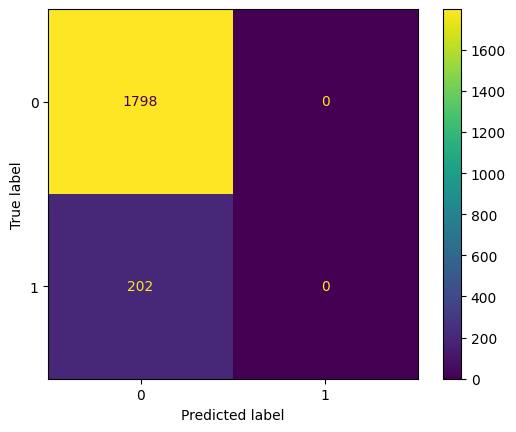

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_test, y_pred)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")